## Knee Rehabilitation Analysis  
Author: Mariona Espí Planet

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import zscore, gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_distances
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score


filename = '/Users/martaespipou/Documents/knee_data.xlsx' #load the file with all the data
df = pd.read_excel(filename)
display(df.head(3))

#rename columns to make them consistent and have simple names
df.rename(columns={
    'Date': 'date',
    'Time': 'time',
    'Max_flexion': 'max_flexion',
    'Pain': 'pain',
    'after_rehab': 'after_rehab',
    'After exercises': 'after_exercises',
    'days since surgery': 'days_since_surgery'
}, inplace=True)
display(df.head(3))


#check that if values are missing and some basic stats
print("\nDataFrame info:")
df.info()
print("\nMissing values per column:")
display(df.isna().sum())
print("\nBasic stats:")
display(df.describe(include='all').T)

,Date,Time,Max_flexion,Pain,after_rehab,After exercises,days since surgery
0,2025-10-11,15:15:00,80,2,no,no,39
1,2025-10-11,21:47:00,82,2,no,no,39
2,2025-10-12,11:42:00,83,4,no,no,40


,date,time,max_flexion,pain,after_rehab,after_exercises,days_since_surgery
0,2025-10-11,15:15:00,80,2,no,no,39
1,2025-10-11,21:47:00,82,2,no,no,39
2,2025-10-12,11:42:00,83,4,no,no,40



DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                42 non-null     datetime64[ns]
 1   time                42 non-null     object        
 2   max_flexion         42 non-null     int64         
 3   pain                42 non-null     int64         
 4   after_rehab         42 non-null     object        
 5   after_exercises     42 non-null     object        
 6   days_since_surgery  42 non-null     int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 2.4+ KB

Missing values per column:


date                  0
time                  0
max_flexion           0
pain                  0
after_rehab           0
after_exercises       0
days_since_surgery    0
dtype: int64


Basic stats:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,42,NaN,NaN,NaN,2025-10-29 21:08:34.285714176,2025-10-11 00:00:00,2025-10-20 06:00:00,2025-10-29 12:00:00,2025-11-09 12:00:00,2025-11-20 00:00:00,NaN
time,42,42,15:15:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_flexion,42.0,NaN,NaN,NaN,104.571429,80.0,89.25,101.5,118.75,140.0,16.801775
pain,42.0,NaN,NaN,NaN,3.261905,0.0,2.0,3.0,4.75,7.0,1.578198
after_rehab,42,2,no,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
after_exercises,42,2,yes,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days_since_surgery,42.0,NaN,NaN,NaN,57.095238,39.0,47.25,56.5,67.5,78.0,11.767689


In [8]:
#used one-hot-encoding to convert numeric to binary variables
df['max_flexion'] = pd.to_numeric(df['max_flexion'], errors='coerce')
df['pain'] = pd.to_numeric(df['pain'], errors='coerce')
df['days_since_surgery'] = pd.to_numeric(df['days_since_surgery'], errors='coerce')

# Map yes/no to 0/1
def yesno_to_int(series, fillna=0):
    mapping = {'yes': 1, 'y': 1, 'true': 1, '1': 1,
               'no': 0, 'n': 0, 'false': 0, '0': 0}
    return series.astype(str).str.strip().str.lower().map(mapping).fillna(fillna).astype(int)

df['after_rehab'] = yesno_to_int(df['after_rehab'])
df['after_exercises'] = yesno_to_int(df['after_exercises'])

print("\nTypes after conversion:")
display(df.dtypes)

#sort chronologically, first by date and then by time
df = df.sort_values(by=['date','time']).reset_index(drop=True)
df.index.name = 'row'
display(df.head(5))


Types after conversion:


date                  datetime64[ns]
time                          object
max_flexion                    int64
pain                           int64
after_rehab                    int64
after_exercises                int64
days_since_surgery             int64
dtype: object

,date,time,max_flexion,pain,after_rehab,after_exercises,days_since_surgery
row,,,,,,,
0,2025-10-11,15:15:00,80,2,0,0,39
1,2025-10-11,21:47:00,82,2,0,0,39
2,2025-10-12,11:42:00,83,4,0,0,40
3,2025-10-13,20:31:00,86,2,0,1,41
4,2025-10-14,08:02:00,83,3,0,0,42


In [9]:
#we will add 3 columns from derived features
df['flexion_delta'] = df['max_flexion'].diff() #difference of flexion from the day before
df['pain_delta'] = df['pain'].diff() #difference of pain from the previous day
df['normalized_flexion'] = df['max_flexion'] / df['max_flexion'].max() #normalized flexion [0-1]

display(df[['date','time','max_flexion','flexion_delta','pain','pain_delta','normalized_flexion']].head(8))
#first columns for flexion_delta and pain_delta are NaNs since there is no previous day to compare

,date,time,max_flexion,flexion_delta,pain,pain_delta,normalized_flexion
row,,,,,,,
0,2025-10-11,15:15:00,80,NaN,2,NaN,0.571429
1,2025-10-11,21:47:00,82,2.0,2,0.0,0.585714
2,2025-10-12,11:42:00,83,1.0,4,2.0,0.592857
3,2025-10-13,20:31:00,86,3.0,2,-2.0,0.614286
4,2025-10-14,08:02:00,83,-3.0,3,1.0,0.592857
5,2025-10-14,20:44:00,89,6.0,5,2.0,0.635714
6,2025-10-15,08:51:00,86,-3.0,2,-3.0,0.614286
7,2025-10-16,21:50:00,84,-2.0,0,-2.0,0.600000


In [10]:
#imputate missing values of flexion_delta, pain_delta if any
df['max_flexion'] = df['max_flexion'].interpolate(method='linear', limit_direction='both') #interpolate max_flexion linearly
df['pain'] = df['pain'].ffill().bfill() #forward-fill and back-fill pain
df['flexion_delta'] = df['max_flexion'].diff() #recompute deltas after imputation
df['pain_delta'] = df['pain'].diff()

display(df.head())

,date,time,max_flexion,pain,after_rehab,after_exercises,days_since_surgery,flexion_delta,pain_delta,normalized_flexion
row,,,,,,,,,,
0,2025-10-11,15:15:00,80,2,0,0,39,NaN,NaN,0.571429
1,2025-10-11,21:47:00,82,2,0,0,39,2.0,0.0,0.585714
2,2025-10-12,11:42:00,83,4,0,0,40,1.0,2.0,0.592857
3,2025-10-13,20:31:00,86,2,0,1,41,3.0,-2.0,0.614286
4,2025-10-14,08:02:00,83,3,0,0,42,-3.0,1.0,0.592857


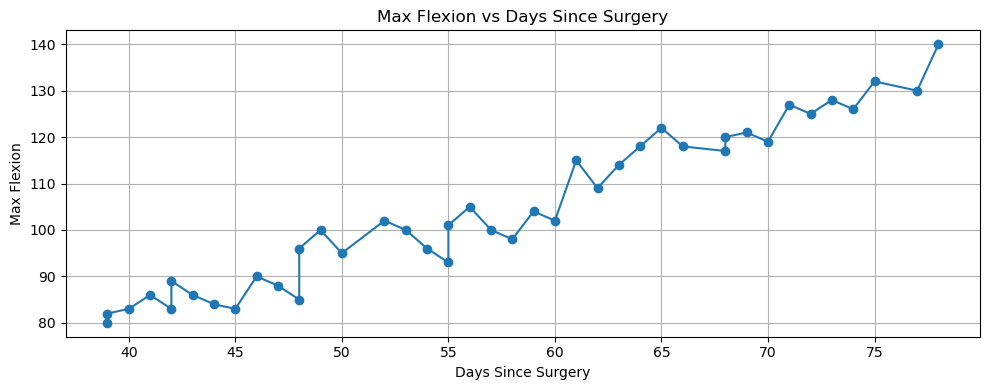

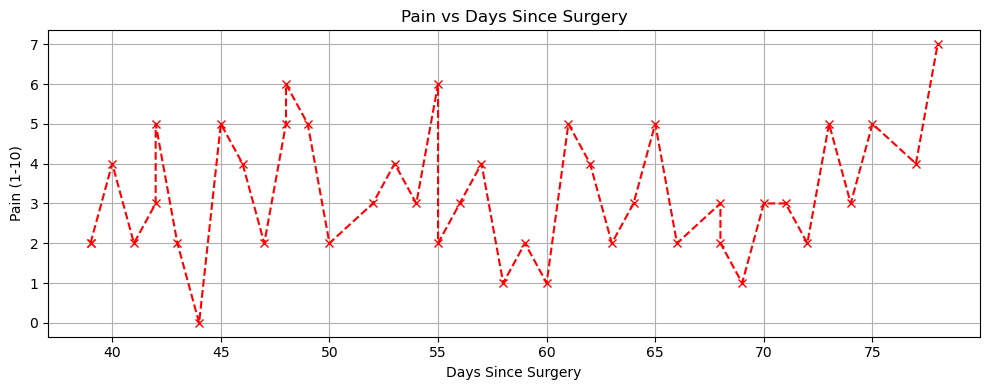

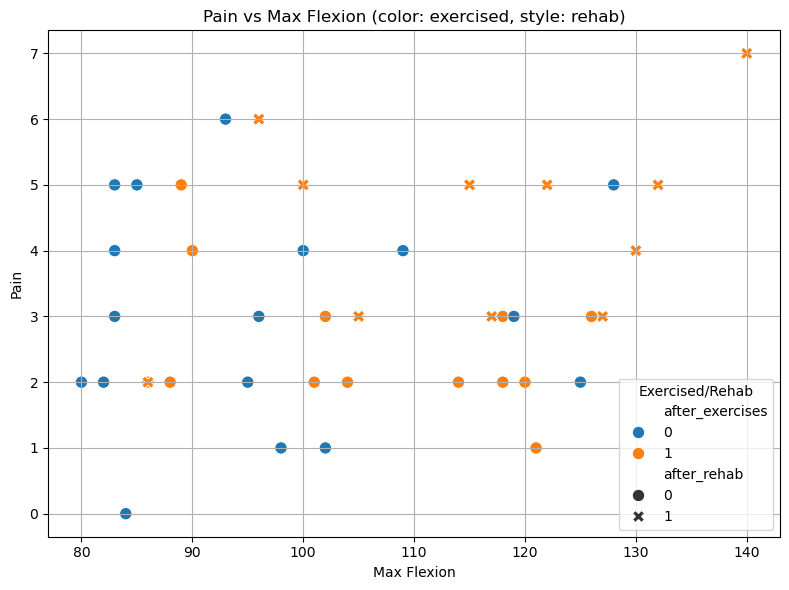

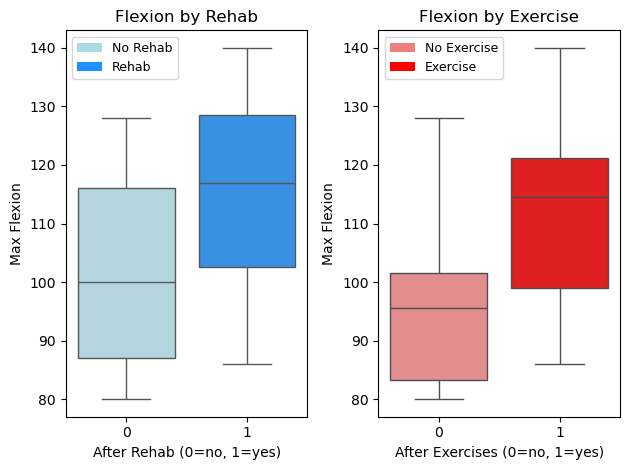

In [11]:
#exploratoy data analysis, some visualizations of our data
#line plot: max_flexion vs days_since_surgery
plt.figure(figsize=(10,4))
plt.plot(df['days_since_surgery'], df['max_flexion'], marker='o', linestyle='-')
plt.title("Max Flexion vs Days Since Surgery")
plt.xlabel("Days Since Surgery")
plt.ylabel("Max Flexion")
plt.grid(True)
plt.tight_layout()
plt.show()


#line plot: pain vs days_since_surgery
plt.figure(figsize=(10,4))
plt.plot(df['days_since_surgery'], df['pain'], marker='x', linestyle='--', color='r')
plt.title("Pain vs Days Since Surgery")
plt.xlabel("Days Since Surgery")
plt.ylabel("Pain (1-10)")
plt.grid(True)
plt.tight_layout()
plt.show()


#scatter plot: pain vs max_flexion
plt.figure(figsize=(8,6))
sns.scatterplot(x='max_flexion', y='pain', hue='after_exercises', style='after_rehab', data=df, s=80)
plt.title("Pain vs Max Flexion (color: exercised, style: rehab)")
plt.xlabel("Max Flexion")
plt.ylabel("Pain")
plt.legend(title="Exercised/Rehab")
plt.grid(True)
plt.tight_layout()
plt.show()


#boxplots
#flexion by rehab
plt.subplot(1,2,1)
sns.boxplot(
    x='after_rehab', 
    y='max_flexion', 
    hue='after_rehab',        
    data=df,
    palette={0: 'lightblue', 1: 'dodgerblue'},
    dodge=False,             
    legend=False             
)
plt.title("Flexion by Rehab")
plt.xlabel("After Rehab (0=no, 1=yes)")
plt.ylabel("Max Flexion")
legend_elements = [Patch(facecolor='lightblue', label='No Rehab'),
                   Patch(facecolor='dodgerblue', label='Rehab')]
plt.legend(handles=legend_elements, loc='upper left', fontsize=9)

#flexion by exercise
plt.subplot(1,2,2)
sns.boxplot(
    x='after_exercises', 
    y='max_flexion', 
    hue='after_exercises', 
    data=df,
    palette={0: 'lightcoral', 1: 'red'},
    dodge=False,
    legend=False
)
plt.title("Flexion by Exercise")
plt.xlabel("After Exercises (0=no, 1=yes)")
plt.ylabel("Max Flexion")
legend_elements = [Patch(facecolor='lightcoral', label='No Exercise'),
                   Patch(facecolor='red', label='Exercise')]
plt.legend(handles=legend_elements, loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

Euclidean distance matrix:
[[0.         0.43695832 1.61961917 ... 5.02583675 4.51387422 6.24821561]
 [0.43695832 0.         1.6106323  ... 4.86175742 4.49367128 6.04946761]
 [1.61961917 1.6106323  0.         ... 4.41393682 4.43813152 5.34279374]
 ...
 [5.02583675 4.86175742 4.41393682 ... 0.         2.2970257  1.67581753]
 [4.51387422 4.49367128 4.43813152 ... 2.2970257  0.         3.74439965]
 [6.24821561 6.04946761 5.34279374 ... 1.67581753 3.74439965 0.        ]]
Shape of distance matrices: (42, 42)

Cluster counts:


cluster
2    18
0    14
1    10
Name: count, dtype: int64

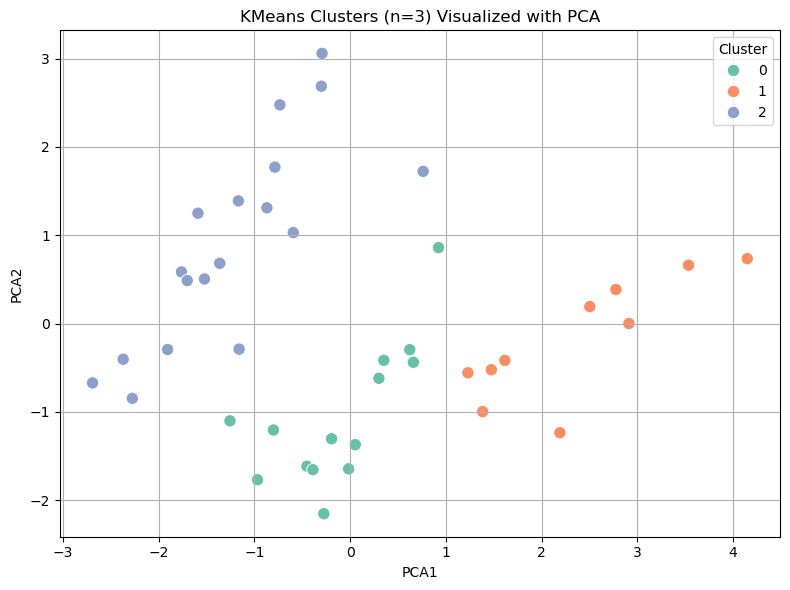


Cluster summary (mean values):


,max_flexion,pain,after_rehab,after_exercises
cluster,,,,
0,104.500000,2.500000,0.071429,1.0
1,118.400000,4.600000,1.000000,1.0
2,96.944444,3.111111,0.000000,0.0


In [12]:
#compute some similarity and clustering
#select features for clustering
features = ['max_flexion', 'pain', 'flexion_delta', 'pain_delta', 'after_rehab', 'after_exercises']
X = df[features].copy()

#fill first-row NaNs in deltas with 0 for clustering
X['flexion_delta'] = X['flexion_delta'].fillna(0)
X['pain_delta'] = X['pain_delta'].fillna(0)

#standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#compute similarity/distance matrices
euclid_dist = euclidean_distances(X_scaled)
manhattan_dist = manhattan_distances(X_scaled)
cosine_dist = cosine_distances(X_scaled)
print("Euclidean distance matrix:")
print(euclid_dist)
print("Shape of distance matrices:", euclid_dist.shape)


#KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)
print("\nCluster counts:")
display(df['cluster'].value_counts())


#PCA for visualization (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PCA1'] = X_pca[:,0]
df['PCA2'] = X_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='Set2',
    data=df,
    s=80
)
plt.title(f"KMeans Clusters (n={n_clusters}) Visualized with PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


#interpret clusters
cluster_summary = df.groupby('cluster')[['max_flexion','pain','after_rehab','after_exercises']].mean()
print("\nCluster summary (mean values):")
display(cluster_summary)

Clustering revealed three types of recovery days: Cluster 0 represents good recovery days with moderate flexion and low pain, 
usually involving exercise but little rehab; Cluster 1 corresponds to intense rehab days with high flexion but higher pain; 
and Cluster 2 includes low-activity or regression days with lower flexion, moderate pain, and no rehab or exercise. 
Overall, the clusters highlight distinct patterns in recovery, showing which days are more effective and which may indicate setbacks.


In [13]:
#outlier detection, if any
#first we prepare the numeric features
features = ['max_flexion', 'pain', 'flexion_delta', 'pain_delta']
X = df[features].copy()
X['flexion_delta'] = X['flexion_delta'].fillna(0)
X['pain_delta'] = X['pain_delta'].fillna(0)

#we use z-score to find extreme values
z_scores = X.apply(zscore)
z_thresh = 3
df['outlier_extreme'] = (z_scores.abs() > z_thresh).any(axis=1)

print("Extreme value outliers (Z-score):")
display(df[df['outlier_extreme']][['date','time','max_flexion','pain','after_rehab','after_exercises','days_since_surgery']])

#we use the probability density methos
kde = gaussian_kde(X.T) #compute likelihood of each point under KDE
densities = kde.evaluate(X.T)
#consider low-density points as outliers
density_thresh = np.percentile(densities, 5)
df['outlier_density'] = densities < density_thresh

print("Probability density outliers (lowest 5% density):")
display(df[df['outlier_density']][['date','time','max_flexion','pain','after_rehab','after_exercises','days_since_surgery']])

#we used the density/partition-based methos
lof = LocalOutlierFactor(n_neighbors=5, contamination=0.1)
df['outlier_lof'] = lof.fit_predict(X) == -1  # -1 indicates outlier

print("Density-based outliers:")
display(df[df['outlier_lof']][['date','time','max_flexion','pain','after_rehab','after_exercises','days_since_surgery']])

#summary of results
print(f"Number of outliers detected by method:")
print("Extreme values (Z-score):", df['outlier_extreme'].sum())
print("Probability density:", df['outlier_density'].sum())
print("Density/partition-based:", df['outlier_lof'].sum())

Extreme value outliers (Z-score):


,date,time,max_flexion,pain,after_rehab,after_exercises,days_since_surgery
row,,,,,,,


Probability density outliers (lowest 5% density):


,date,time,max_flexion,pain,after_rehab,after_exercises,days_since_surgery
row,,,,,,,
19,2025-10-28,22:50:00,101,2,0,1,55
25,2025-11-03,09:57:00,115,5,1,1,61
41,2025-11-20,10:02:00,140,7,1,1,78


Density-based outliers:


,date,time,max_flexion,pain,after_rehab,after_exercises,days_since_surgery
row,,,,,,,
9,2025-10-19,20:30:00,90,4,0,1,46
25,2025-11-03,09:57:00,115,5,1,1,61
26,2025-11-04,20:45:00,109,4,0,0,62
39,2025-11-17,15:56:00,132,5,1,1,75
41,2025-11-20,10:02:00,140,7,1,1,78


Number of outliers detected by method:
Extreme values (Z-score): 0
Probability density: 3
Density/partition-based: 5


The extreme value method (Z-score) did not flag any days, indicating that there were no measurements drastically far from the mean in any single feature. This suggests that most of the recovery data falls within a reasonable range without extreme outliers in individual metrics like flexion or pain.

The probability density method (KDE) identified three days (Oct 28, Nov 3, Nov 20) as low-density points, meaning that their combination of flexion, pain, and deltas was unusual compared to typical recovery days. The density/partition-based method (LOF) flagged five days (Oct 19, Nov 3, Nov 4, Nov 17, Nov 20) as locally unusual, highlighting days whose overall recovery pattern differs from neighboring days in the dataset.

Comparing these methods shows that certain days, such as Nov 3 and Nov 20, are consistently detected as outliers, suggesting intense rehab sessions or exceptional efforts. Some unusual days, like Nov 4, occur without rehab or exercise, possibly indicating regression or setbacks. Overall, outlier detection helps identify atypical recovery days, offering insights into both progress and potential issues in the rehabilitation process.

Thus, the detected outliers were not removed from the dataset, as they represent meaningful recovery events rather than measurement errors. These days are retained and interpreted as important signals in the recovery process.

In [14]:
#create binary variables
df['pain_low'] = df['pain'] <= 3
df['flexion_high'] = df['max_flexion'] > 100
df['flexion_increased'] = df['flexion_delta'] > 0
df['exercised'] = df['after_exercises'] == 1
df['rehab'] = df['after_rehab'] == 1

#we convert each day into a transaction
item_columns = {
    'pain_low': 'pain_low',
    'flexion_high': 'flexion_high',
    'flexion_increased': 'flexion_increased',
    'exercised': 'exercised',
    'rehab': 'rehab'
}

transactions = [
    [item for item, col in item_columns.items() if df.loc[i, col]]
    for i in df.index
]

#show the first 10 transactions
for i, t in enumerate(transactions[:10]):
    print(f"Day {i}: {t}")

Day 0: ['pain_low']
Day 1: ['pain_low', 'flexion_increased']
Day 2: ['flexion_increased']
Day 3: ['pain_low', 'flexion_increased', 'exercised']
Day 4: ['pain_low']
Day 5: ['flexion_increased', 'exercised']
Day 6: ['pain_low', 'exercised', 'rehab']
Day 7: ['pain_low']
Day 8: []
Day 9: ['flexion_increased', 'exercised']


In [15]:
#we compute the item support
item_support = {}
for item in ['pain_low', 'flexion_high', 'flexion_increased', 'exercised', 'rehab']:
    count = sum(item in t for t in transactions)
    item_support[item] = count / len(transactions)
item_support

#we filter frequent items using min support
min_support = 0.2  # appears in at least 20% of days
frequent_items = {
    item: supp
    for item, supp in item_support.items()
    if supp >= min_support
}
frequent_items

#number of transactions
n_transactions = len(transactions)
rules = []
items = list(frequent_items.keys())
for a in items:
    for b in items:
        if a == b:
            continue  # skip rules like A -> A
        # count transactions where both a and b appear
        count_ab = sum(
            (a in t) and (b in t)
            for t in transactions
        )
        support_ab = count_ab / n_transactions
        if support_ab >= min_support:
            confidence = support_ab / item_support[a]
            lift = confidence / item_support[b]
            rules.append({
                'antecedent': a,
                'consequent': b,
                'support': support_ab,
                'confidence': confidence,
                'lift': lift
            })

#we convert the rules to a dataframe
rules_df = pd.DataFrame(rules)
rules_df.sort_values(by='lift', ascending=False)

#we filter strong rules, confidence >=60% is a reliable rule and lift > 1 is a non-random association
strong_rules = rules_df[(rules_df['confidence'] >= 0.6) & (rules_df['lift'] > 1)].sort_values(by='lift', ascending=False)
strong_rules

,antecedent,consequent,support,confidence,lift
13,rehab,exercised,0.261905,1.000000,1.750000
8,flexion_increased,exercised,0.428571,0.857143,1.500000
11,exercised,flexion_increased,0.428571,0.750000,1.500000
5,flexion_high,exercised,0.404762,0.772727,1.352273
10,exercised,flexion_high,0.404762,0.708333,1.352273
4,flexion_high,flexion_increased,0.333333,0.636364,1.272727
7,flexion_increased,flexion_high,0.333333,0.666667,1.272727
0,pain_low,flexion_high,0.357143,0.600000,1.145455
3,flexion_high,pain_low,0.357143,0.681818,1.145455
2,pain_low,exercised,0.357143,0.600000,1.050000


The association rule analysis shows that rehab days are always paired with exercise, and exercising strongly increases the likelihood of flexion improvement. High flexion days also tend to coincide with exercise, while low pain moderately correlates with higher flexion. Overall, these rules confirm that consistent exercise and rehab are linked to better knee recovery, quantifying patterns of effective and less active recovery days.

Linear Regression R2: 0.47479081818890545
Random Forest R2: -2.680119920174168


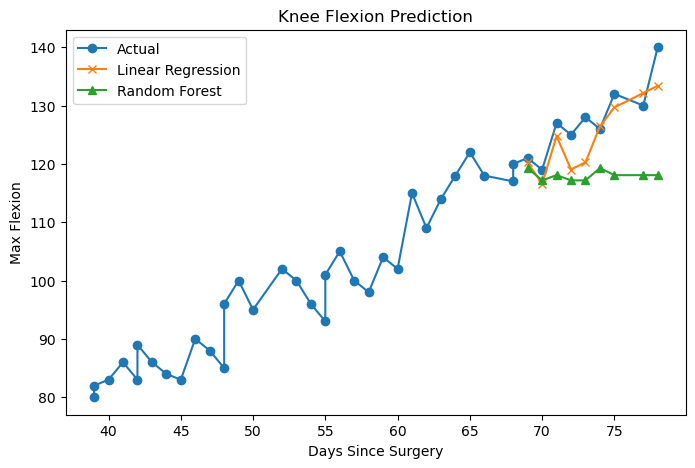

Predicted max flexion on day 100:
 - Linear Regression: 160.56
 - Random Forest: 118.07


In [16]:
#predictive modeling
#features and target
X = df[['days_since_surgery', 'after_exercises', 'after_rehab']]
y = df['max_flexion']

#train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

#random forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

#evaluate models
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Random Forest R2:", r2_score(y_test, y_pred_rf))

#plot the predictions versus the actual data points
plt.figure(figsize=(8,5))
plt.plot(df['days_since_surgery'], df['max_flexion'], label='Actual', marker='o')
plt.plot(X_test['days_since_surgery'], y_pred_lr, label='Linear Regression', marker='x')
plt.plot(X_test['days_since_surgery'], y_pred_rf, label='Random Forest', marker='^')
plt.xlabel("Days Since Surgery")
plt.ylabel("Max Flexion")
plt.title("Knee Flexion Prediction")
plt.legend()
plt.show()

#we make a prediction for day 100 assuming we did exercise and went to rehab
future_day = pd.DataFrame({'days_since_surgery': [100],'after_exercises': [1],'after_rehab': [1]})
pred_lr_day100 = lr_model.predict(future_day)[0]
pred_rf_day100 = rf_model.predict(future_day)[0]
print(f"Predicted max flexion on day 100:")
print(f" - Linear Regression: {pred_lr_day100:.2f}")
print(f" - Random Forest: {pred_rf_day100:.2f}")

Linear Regression explains about 47% of the variance in knee flexion, capturing the general recovery trend over days since surgery and the effect of exercise and rehab. The predicted max flexion for day 100 (~160°) reflects continued recovery, though it may slightly overestimate due to extrapolation beyond observed data.

The Random Forest model performs poorly (R² ≈ -2.7) because of the small dataset and sparse features, leading to overfitting and unrealistic predictions (~118° for day 100). 